In [1]:
using Pkg
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("QuadGK")
Pkg.add("SpecialFunctions")
Pkg.add("Optim")
Pkg.add("Printf")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))

   Updating registry at `/opt/julia/registries/General`
######################################################################### 100.0%                76.1%
  Resolving package versions...
  Installed MbedTLS_jll ────────────────── v2.16.8+1
  Installed Adapt ──────────────────────── v2.3.0
  Installed Measures ───────────────────── v0.3.1
  Installed HDF5_jll ───────────────────── v1.10.5+7
  Installed EarCut_jll ─────────────────── v2.1.5+1
  Installed FreeType2_jll ──────────────── v2.10.1+5
  Installed DataValueInterfaces ────────── v1.0.0
  Installed Plots ──────────────────────── v1.8.1
  Installed Xorg_libXau_jll ────────────── v1.0.9+4
  Installed Ogg_jll ────────────────────── v1.3.4+2
  Installed Xorg_libXi_jll ─────────────── v1.7.10+4
  Installed Xorg_libxcb_jll ────────────── v1.13.0+3
  Installed Missings ───────────────────── v0.4.4
  Installed JpegTurbo_jll ──────────────── v2.0.1+3
  Installed Requires ───────────────────── v1.1.0
  Installed Opus_jll ────────────────

    Cloning git-repo `https://github.com/JuliaReliab/Origin.jl.git`


g: [========================================>]  100.0 %

   Updating git-repo `https://github.com/JuliaReliab/Origin.jl.git`


  Resolving package versions...


Updating `/opt/julia/environments/v1.5/Project.toml`
  [421443cc] + Origin v0.1.2 `https://github.com/JuliaReliab/Origin.jl.git#master`
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [421443cc] + Origin v0.1.2 `https://github.com/JuliaReliab/Origin.jl.git#master`
    Cloning git-repo `https://github.com/JuliaReliab/Deformula.jl.git`


g: [========================================>]  100.0 %

   Updating git-repo `https://github.com/JuliaReliab/Deformula.jl.git`


  Resolving package versions...


Updating `/opt/julia/environments/v1.5/Project.toml`
  [92955551] + Deformula v0.1.3 `https://github.com/JuliaReliab/Deformula.jl.git#master`
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [92955551] + Deformula v0.1.3 `https://github.com/JuliaReliab/Deformula.jl.git#master`
    Cloning git-repo `https://github.com/JuliaReliab/SparseMatrix.jl.git`


g: [========================================>]  100.0 %

   Updating git-repo `https://github.com/JuliaReliab/SparseMatrix.jl.git`


  Resolving package versions...


Updating `/opt/julia/environments/v1.5/Project.toml`
  [b2a93422] + SparseMatrix v0.2.1 `https://github.com/JuliaReliab/SparseMatrix.jl.git#master`
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [b2a93422] + SparseMatrix v0.2.1 `https://github.com/JuliaReliab/SparseMatrix.jl.git#master`
    Cloning git-repo `https://github.com/JuliaReliab/NMarkov.jl.git`


g: [========================================>]  100.0 %]  96.4 %.8 %

   Updating git-repo `https://github.com/JuliaReliab/NMarkov.jl.git`


  Resolving package versions...
Updating `/opt/julia/environments/v1.5/Project.toml`
  [c5cca998] + NMarkov v0.3.2 `https://github.com/JuliaReliab/NMarkov.jl.git#master`
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [c5cca998] + NMarkov v0.3.2 `https://github.com/JuliaReliab/NMarkov.jl.git#master`


In [1]:
using SparseArrays
using NMarkov
using Plots
using Distributions
using QuadGK
using SpecialFunctions
using Optim
using Printf
using DataFrames
using CSV
using SparseMatrix

┌ Info: Precompiling NMarkov [c5cca998-98d3-11ea-1288-bb4300628a81]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


In [2]:
import NMarkov.eye
function eye(M::AbstractMatrix)
    eye(size(M)[1])
end

eye (generic function with 3 methods)

## Zhao and Nakagawa

In [3]:
function GN(n, D0, D1)
    k = size(D0)[1]
    Qn = spzeros(AbstractMatrix{Float64}, n, n) # blockmatrix
    I = eye(D0)
    b = spzeros(AbstractMatrix{Float64}, n, 1)
    for i = 1:n
        Qn[i,i] = D0
    end
    for i = 1:n-1
        Qn[i,i+1] = D1
    end
    a = zeros(k, n*k)
    a[1:k,1:k] = I
    for i = 1:n
        b[i,1] = I
    end
    a, sparse(block(Qn)), Matrix(sparse(block(b)))
end

function gN(n, D0, D1)
    k = size(D0)[1]
    Qn = spzeros(AbstractMatrix{Float64}, n, n) # blockmatrix
    I = eye(D0)
    for i = 1:n
        Qn[i,i] = D0
    end
    for i = 1:n-1
        Qn[i,i+1] = D1
    end
    a = zeros(k, n*k)
    a[1:k,1:k] = I
    b = zeros(n*k, k)
    b[((n-1)*k)+1:(n*k),1:k] = D1
    a, sparse(block(Qn)), b
end

gN (generic function with 1 method)

In [11]:
function PfProb(t0, n, D0, D1, dist)
    a, A, b = GN(n, D0, D1)
    p1 = a * mexpmix(A, b, bounds = (0.0, t0), rmax = 10000) do t
        pdf(dist, t)
    end
    p3 = a * mexp(A, b, t0, rmax = 10000)

    a, A, b = gN(n, D0, D1)
    _, tmp = mexpcmix(A, b, bounds = (0.0, t0), rmax = 10000) do t
        pdf(dist, t)
    end
    p2 = a * tmp
    _, tmp = mexpc(A, b, t0, rmax = 10000)
    p4 = a * tmp

    P = p1 + p2 + ccdf(dist, t0) * (p3 + p4)
    gth(P)
end

PfProb (generic function with 1 method)

In [21]:
function gbar(t, n, pss, D0, D1)
    a, A, b = GN(n, D0, D1)
    sum((a * exp(Matrix(A)*t) * b)' * pss)
end

gbar (generic function with 2 methods)

In [8]:
function T(t0, dist)
    res = quadgk(x -> ccdf(dist, x), 0, t0, rtol=1e-8)
    res[1]
end

T (generic function with 1 method)

In [9]:
function C(t0, dist, cp, cf)
    cp + (cf - cp)*cdf(dist, t0)
end

C (generic function with 1 method)

In [10]:
# standard age replacement
As(t0, dist, cp, cf) = C(t0, dist, cp, cf) / T(t0, dist)

As (generic function with 1 method)

In [39]:
# opportunity
function Aop(t0, n, dist, cp, cf, D0, D1)
    pss = PfProb(t0, n, D0, D1, dist)
    res1 = quadgk(x -> ccdf(dist, x) * gbar(x, n, pss, D0, D1), 0, t0, rtol=1e-8)
    res2 = quadgk(x -> pdf(dist, x) * gbar(x, n, pss, D0, D1), 0, t0, rtol=1e-8)
    (cp + (cf - cp) * res2[1]) / res1[1]
end

Aop (generic function with 1 method)

In [14]:
function failure_param(;mttf, cv)
    m = optimize(m -> (gamma(1+2/m)/gamma(1+1/m)^2 - 1.0 - cv^2)^2, 0.0001, 10.0).minimizer
    eta = mttf / gamma(1+1/m)
    dist = Weibull(m, eta)

    println("failure shape parameter ", m)
    println("failure scale parameter ", eta)
    println("failure mttf ", mttf)
    println("failure cv ", cv)
    return dist
end

failure_param (generic function with 1 method)

In [13]:
function poisson_param(;mttop)
    # poisson
    D0 = Float64[-2 1; 1 -2]
    D1 = Float64[1 0; 0 1]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", sqrt(mo2 - mo^2)/mo)
    return D0, D1, 1.0
end

function hyporenewal_param(;mttop, b)
    # hypo renewal
#     b = Float64[1, 1]
    D0 = Float64[-b[1] b[1]; 0 -b[2]]
    D1 = Float64[0 0; b[2] 0]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

function hyperrenewal_param(;mttop, u, b)
    # hyper exp
    D0 = Float64[-b[1] 0; 0 -b[2]]
    D1 = reshape(b, 2, 1) * reshape(u, 1, 2)

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv

end

function mmpp_param(;mttop, u, b)
    # mmpp
    D0 = Float64[-(u[1]+b[1]) u[1]; u[2] -(u[2]+b[2])]
    D1 = Float64[b[1] 0; 0 b[2]]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

mmpp_param (generic function with 1 method)

In [49]:
cp, cf = 1.0, 10.0
dist = failure_param(mttf = 10.0, cv = 0.1)
D0, D1 = hyporenewal_param(mttop = 1.0, b=[1,2])

failure shape parameter 9.999999703209413
failure scale parameter 10.511370074337558
failure mttf 10.0
failure cv 0.1
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785


([-1.1666666666666665 1.1666666666666665; 0.0 -2.333333333333333], [0.0 0.0; 2.333333333333333 0.0], 0.9147320339189785)

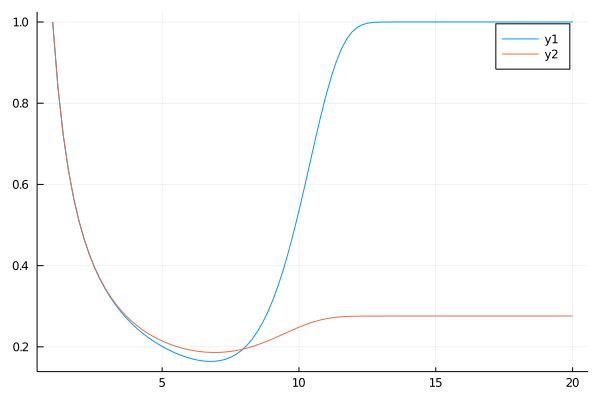

In [48]:
ts = LinRange(1, 20.0, 100)
value = [As(t0, dist, cp, cf) for t0 = ts]
value1 = [Aop(t0, 5, dist, cp, cf, D0, D1) for t0 = ts];
plot(ts, value)
plot!(ts, value1)

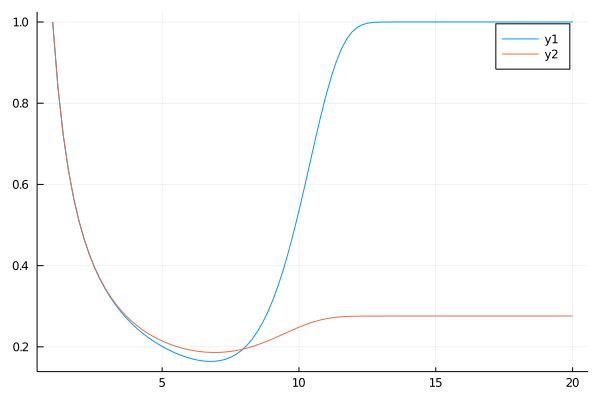